# NLP Disaster Tweets Kaggle Mini-Project

## Objective
The goal of this project is to build a Recurrent Neural Network (RNN) model to classify whether a tweet is about a real disaster or not. The link for the Kaggle competition is : https://www.kaggle.com/c/nlp-getting-started/overview



##  Brief description of the problem and data (5 pts) 

In this project, the goal is to train a computer model to detect whether a tweet is about a real disaster or not. This problem is part of a Kaggle competition called “Natural Language Processing with Disaster Tweets.”

The dataset contains short text messages (tweets) and their labels. Each tweet is labeled as 1 if it is related to a real disaster, and 0 if it is not. The training data includes over 7,600 tweets with their corresponding labels, and the test set contains more than 3,200 tweets without labels. The tweets are stored in a CSV file with columns like tweet text, optional keywords, and optional location.

Since this is a binary classification task, the model will learn from the labeled tweets to predict whether new, unseen tweets describe real disasters or not. This task is a good example of a Natural Language Processing (NLP) problem, where the input data is human-written text and the goal is to classify its meaning using deep learning methods like Recurrent Neural Networks (RNNs)

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow tqdm

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Before building the model, we perform a comprehensive validation of the dataset to ensure data quality and guide preprocessing decisions. We begin by inspecting the basic structure of the dataset, including the number of rows and available columns. This gives us an overview of the data we’re working with.

Next, we check for missing values in critical columns such as text, keyword, and location. While the text field is complete, we observe that keyword and location contain some missing entries. However, since these fields are not used in our model, we retain them as-is and do not perform any imputation or row removal at this stage.

We also assess the presence of duplicate rows, which might indicate redundant or noisy data. Although we count the number of duplicates, we do not remove them at this stage, as their impact may be minimal or neutral.

A key part of the analysis is examining the class distribution of the target column, which indicates whether a tweet is disaster-related (1) or not (0). We compute both the counts and percentages of each class. The dataset is moderately imbalanced, with a slight skew that could affect model performance. We take note of this to potentially address it during training or evaluation.

Finally, we analyze the length of tweets by calculating the word count for each entry. This helps us determine an appropriate maximum sequence length for model input. Based on the descriptive statistics, most tweets are under 30–35 words long, so we choose this as a safe upper limit for padding input sequences to ensure uniformity across the dataset.


In [3]:
def validate_dataset(df):
    print("Dataset Validation Report")
    print("-" * 50)
    
    print(f"Total rows: {len(df)}")
    print("Columns:", list(df.columns))
    
    print("\nMissing values:")
    print(df.isnull().sum())

    num_duplicates = df.duplicated().sum()
    print(f"\nNumber of duplicate rows: {num_duplicates}")
    
    if 'target' in df.columns:
        print("\nClass distribution (target column):")
        class_counts = df['target'].value_counts()
        print(class_counts)

        print("\nClass distribution (as %):")
        class_props = df['target'].value_counts(normalize=True) * 100
        print(class_props.round(2))

        imbalance = abs(class_props[0] - class_props[1])
        if imbalance < 10:
            print("The dataset is fairly balanced.")
        elif imbalance < 30:
            print("The dataset is moderately imbalanced. You may monitor class-wise metrics.")
        else:
            print("The dataset is highly imbalanced. Consider rebalancing techniques.")

    df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
    length_stats = df['text_length'].describe()
    print("\nTweet length (word count) stats:")
    print(length_stats)

    print(f"\nBased on the stats, a max sequence length of ~{int(length_stats['max'])} is safe for padding.")
    print("You could choose 30–35 tokens as a practical upper limit for model input.")
    
    print("-" * 50)

train_df = pd.read_csv("train.csv")
validate_dataset(train_df)

Dataset Validation Report
--------------------------------------------------
Total rows: 7613
Columns: ['id', 'keyword', 'location', 'text', 'target']

Missing values:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Number of duplicate rows: 0

Class distribution (target column):
target
0    4342
1    3271
Name: count, dtype: int64

Class distribution (as %):
target
0    57.03
1    42.97
Name: proportion, dtype: float64
The dataset is moderately imbalanced. You may monitor class-wise metrics.

Tweet length (word count) stats:
count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text_length, dtype: float64

Based on the stats, a max sequence length of ~31 is safe for padding.
You could choose 30–35 tokens as a practical upper limit for model input.
--------------------------------------------------


### Clean the Data

To prepare the raw tweet text for modeling, we apply a custom text cleaning function. This function converts all text to lowercase to ensure uniformity and removes noise that could interfere with learning. Specifically, it strips out URLs, user mentions (e.g., @username), and special characters, while retaining the words from hashtags by simply removing the # symbol. It also eliminates numbers and punctuation, and condenses multiple spaces into a single space. The cleaned version of each tweet is stored in a new column called clean_text. This preprocessing step helps reduce vocabulary size, improve consistency, and ensures the text is in a suitable format for tokenization and modeling with Recurrent Neural Networks (RNNs).



In [4]:
def clean_dataset(df):
    def clean_text(text):
        text = str(text).lower()                         # Lowercase
        text = re.sub(r"http\S+|www\S+", "", text)       # Remove URLs
        text = re.sub(r"@\w+", "", text)                 # Remove mentions
        text = re.sub(r"#", "", text)                    # Remove hashtag symbol, keep word
        text = re.sub(r"[^a-z\s]", "", text)             # Remove numbers, punctuation, special chars
        text = re.sub(r"\s+", " ", text).strip()         # Remove extra whitespace
        return text

    print("Cleaning tweet text...")
    df['clean_text'] = df['text'].apply(clean_text)
    print("Cleaning tweet text complete...")
    return df

train_df = clean_dataset(train_df)


Cleaning tweet text...
Cleaning tweet text complete...


### Visualize the Data

After cleaning the tweet text, we visualize the dataset to better understand its structure and inform model design. First, we plot the class distribution of the target variable to check whether the dataset is balanced between disaster (1) and non-disaster (0) tweets. This helps us anticipate whether class imbalance might influence training performance. Next, we examine the distribution of tweet lengths by calculating the number of words in each cleaned tweet and visualizing them using a histogram. Most tweets fall within the range of 5 to 25 words, with a peak around 10–15 words. While a small number of tweets exceed 30 words, we choose a maximum sequence length of 30 for padding. This value captures the vast majority of tweets while keeping input size manageable and reducing unnecessary padding that could introduce noise or slow down training.

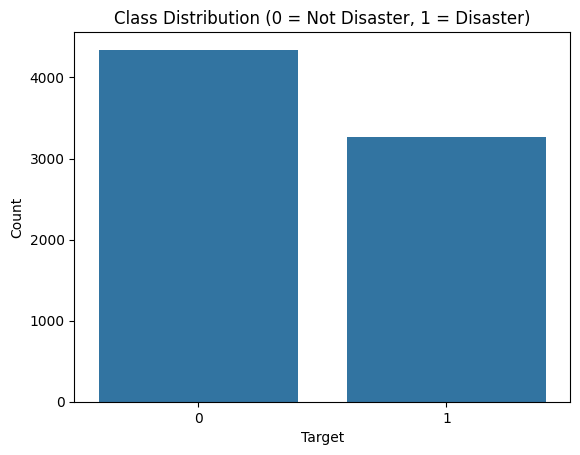

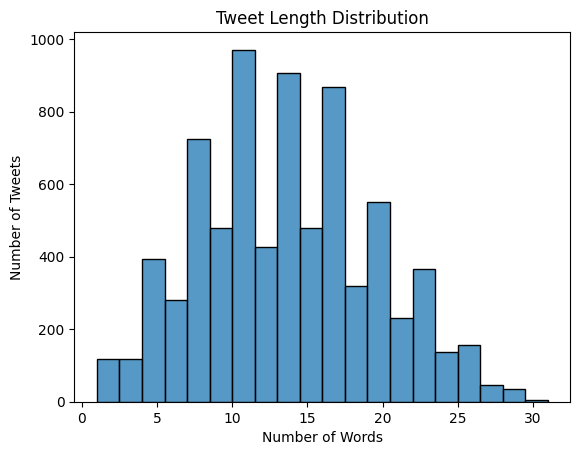

In [5]:
def plot_class_distribution(df):
    sns.countplot(x='target', data=df)
    plt.title('Class Distribution (0 = Not Disaster, 1 = Disaster)')
    plt.xlabel('Target')
    plt.ylabel('Count')
    plt.show()

def plot_tweet_lengths(df):
    df['text_length'] = df['clean_text'].apply(lambda x: len(str(x).split()))
    sns.histplot(df['text_length'], bins=20, kde=False)
    plt.title('Tweet Length Distribution')
    plt.xlabel('Number of Words')
    plt.ylabel('Number of Tweets')
    plt.show()

plot_class_distribution(train_df)
plot_tweet_lengths(train_df)

### Text Preprocessing: Tokenization and Padding

After cleaning the tweets, we convert the text into a numerical format using Keras's Tokenizer. The tokenizer assigns a unique integer to each word based on its frequency. We then convert all tweets to sequences of these integers and apply padding so that all sequences have the same length (max_len = 35). 

We fit the tokenizer only on the training data to avoid data leakage, and reuse it for the test data to ensure consistent word indexing.


In [6]:
# Create and fit tokenizer on cleaned training data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])

# Define max sequence length
max_len = 30

# Tokenize and pad training data
padded_train = pad_sequences(tokenizer.texts_to_sequences(train_df['clean_text']),
                             maxlen=max_len, padding='post', truncating='post')

# Load and clean the test data
test_df = pd.read_csv("test.csv")
test_df = clean_dataset(test_df)

# Tokenize and pad test data using same tokenizer
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['clean_text']),
                            maxlen=max_len, padding='post', truncating='post')

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1


Cleaning tweet text...
Cleaning tweet text complete...


### Summary of EDA

- The dataset contains **7,613 labeled tweets**, each labeled as either disaster-related (target = 1) or not (target = 0).
- No missing values were found in the text or target columns.
- The class distribution is approximately **57% non-disaster (label = 0)** and **43% disaster (label = 1)**, which is fairly balanced.
- We inspected the text for noise and cleaned it by removing URLs, mentions, special characters, and extra whitespace. The cleaned text is stored in a new column clean_text for further processing.
- A histogram of tweet lengths shows that most tweets contain between **10 and 20 words**, with the longest tweets reaching up to **30 words**.
- Based on this, we selected a **maximum sequence length of 30 words** to be used for padding.
- Finally, we converted the cleaned text into sequences of integers using tokenization and applied padding to make all sequences the same length, preparing the data for training RNN-based models.

### Plan of Analysis

Since tweets are short sequences of text and the order of words matters, we will use **Recurrent Neural Networks (RNNs)** to classify them. RNNs are a natural choice for this task because they are designed to handle sequential data and can learn contextual dependencies between words over time.

The cleaned and tokenized tweet data will be converted into padded sequences of integers and fed into RNN-based models. We will train the models to predict whether each tweet is related to a real disaster or not.

During training, we will monitor **accuracy** on both the training and validation sets. After evaluating the models, we will select the best-performing one to generate predictions on the test set for submission to Kaggle.


## Model Architecture (25 pts)

For this project, we use Recurrent Neural Networks (RNNs) because they are well-suited for sequential data like text. RNNs are ideal for NLP tasks where the order and context of words impact meaning — especially in short, informal formats like tweets.

We begin with a baseline model consisting of:
- An embedding layer to convert words into dense vector representations
- A single LSTM layer with 64 units
- Dropout (0.5) for regularization
- A dense output layer with sigmoid activation for binary classification

To improve on this baseline, we experiment with two additional variants:

- **Bidirectional LSTM:** Uses a lower dropout rate (0.3) and wraps the LSTM layer in a bidirectional wrapper to capture both forward and backward context.
- **Stacked LSTM:** Adds a second LSTM layer with return_sequences=True, includes batch normalization, and uses a lower learning rate (0.0005) for better stability with deeper networks.

We compare these models using the same training/validation split and evaluate them based on validation accuracy and loss to determine the best-performing configuration.


### Train/Validation Split and Model Training

Before training, we split our data into training and validation sets using an 80/20 ratio. This allows us to evaluate how well the models are generalizing to unseen data and helps detect overfitting.

We use the tokenized and padded tweet sequences as input (X) and the target labels (y) from train.csv. After the split, we train three RNN-based models:

- **Baseline LSTM Model:** Single LSTM layer with 0.5 dropout and learning rate of 0.001
- **Bidirectional LSTM Variant:** Uses a bidirectional wrapper and 0.3 dropout
- **Stacked LSTM Variant:** Two LSTM layers with batch normalization and a reduced learning rate of 0.0005

Each model is trained using the same training and validation data. During training, we track validation accuracy and loss and use these metrics to compare model performance. We also generate predictions for the Kaggle test set using the best-performing model.


In [7]:
# Split padded data and labels into train and validation sets
X = padded_train
y = train_df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the RNN Model
def build_rnn_model(vocab_size, embedding_dim, max_len,
                    rnn_type='lstm', bidirectional=False, stacked=False,
                    dropout_rate=0.5, learning_rate=0.001):
    
    model = Sequential()
    
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim))
    
    RNN = LSTM if rnn_type == 'lstm' else GRU
    
    if stacked:
        if bidirectional:
            model.add(Bidirectional(RNN(64, return_sequences=True)))
            model.add(Bidirectional(RNN(32)))
        else:
            model.add(RNN(64, return_sequences=True))
            model.add(RNN(32))
        model.add(BatchNormalization())
    else:
        if bidirectional:
            model.add(Bidirectional(RNN(64)))
        else:
            model.add(RNN(64))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])
    
    return model

def train_and_predict_rnn(model, X_train, y_train, X_val, y_val, X_test=None, model_name="Model", epochs=5):
    print(f"\nTraining {model_name}...\n")
    start_time = time.time()
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        verbose=1
    )

    print(f"{model_name} training completed in {(time.time() - start_time)/60:.2f} minutes")

    predicted_labels = None
    if X_test is not None:
        print(f"\nPredicting with {model_name}...\n")
        predictions = model.predict(X_test)
        predicted_labels = (predictions > 0.5).astype(int)

    return history, predicted_labels


In [8]:
# === Train and predict for all 3 model variants ===

# Model 1: Baseline RNN
start_time = time.time()
baseline_model = build_rnn_model(vocab_size, 100, max_len,
                                 bidirectional=False, stacked=False, dropout_rate=0.5, learning_rate=0.001)
history_baseline, preds_baseline = train_and_predict_rnn(
    baseline_model, X_train, y_train, X_val, y_val, X_test, model_name="Baseline RNN", epochs=10)
end_time = time.time()
print(f"Baseline RNN completed in {(end_time - start_time)/60:.2f} minutes\n")



Training Baseline RNN...

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.6182 - loss: 0.6420 - val_accuracy: 0.8004 - val_loss: 0.4548
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.8678 - loss: 0.3431 - val_accuracy: 0.8030 - val_loss: 0.4493
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9191 - loss: 0.2472 - val_accuracy: 0.7859 - val_loss: 0.5684
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.9326 - loss: 0.2025 - val_accuracy: 0.7853 - val_loss: 0.5709
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.9488 - loss: 0.1545 - val_accuracy: 0.7840 - val_loss: 0.6156
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - accuracy: 0.9638 - loss: 0.1020 - val_accuracy: 0.7695 - val_loss: 0.8668
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.9678 - loss: 0.0980 - val_accuracy: 0.7472 - val_loss: 1.0483
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accurac

In [9]:
# Model 2: Bidirectional LSTM
start_time = time.time()
bidirectional_model = build_rnn_model(vocab_size, 100, max_len,
                                      bidirectional=True, stacked=False, dropout_rate=0.3, learning_rate=0.001)
history_bidirectional, preds_bidirectional = train_and_predict_rnn(
    bidirectional_model, X_train, y_train, X_val, y_val, X_test, model_name="Bidirectional RNN", epochs=10)
end_time = time.time()
print(f"Bidirectional RNN completed in {(end_time - start_time)/60:.2f} minutes\n")


Training Bidirectional RNN...

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.6440 - loss: 0.6112 - val_accuracy: 0.8017 - val_loss: 0.4456
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.8707 - loss: 0.3263 - val_accuracy: 0.7991 - val_loss: 0.4578
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.9208 - loss: 0.2175 - val_accuracy: 0.7945 - val_loss: 0.5065
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9491 - loss: 0.1468 - val_accuracy: 0.7676 - val_loss: 0.6427
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.9632 - loss: 0.1042 - val_accuracy: 0.7814 - val_loss: 0.7482
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.9719 - loss: 0.0830 - val_accuracy: 0.7695 - val_loss: 0.8056
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9715 - loss: 0.0725 - val_accuracy: 0.7820 - val_loss: 0.7447
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - ac

In [10]:
# Model 3: Stacked LSTM + BatchNorm
start_time = time.time()
stacked_model = build_rnn_model(vocab_size, 100, max_len,
                                bidirectional=False, stacked=True, dropout_rate=0.5, learning_rate=0.0005)
history_stacked, preds_stacked = train_and_predict_rnn(
    stacked_model, X_train, y_train, X_val, y_val, X_test, model_name="Stacked RNN", epochs=10)
end_time = time.time()
print(f"Stacked RNN completed in {(end_time - start_time)/60:.2f} minutes\n")



Training Stacked RNN...

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.6035 - loss: 0.6352 - val_accuracy: 0.5778 - val_loss: 0.6540
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.8566 - loss: 0.3491 - val_accuracy: 0.7879 - val_loss: 0.5182
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.9089 - loss: 0.2367 - val_accuracy: 0.6566 - val_loss: 0.6566
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9297 - loss: 0.1864 - val_accuracy: 0.6605 - val_loss: 0.8162
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.9506 - loss: 0.1383 - val_accuracy: 0.7131 - val_loss: 0.7715
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.9546 - loss: 0.1346 - val_accuracy: 0.7163 - val_loss: 0.8216
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9647 - loss: 0.1220 - val_accuracy: 0.6316 - val_loss: 1.1303
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy

## Results and Analysis (35 pts)

In this section, we analyze the performance of the three RNN-based models we trained by comparing their training and validation metrics. Our goal is to understand how architectural choices such as using a bidirectional LSTM or stacking multiple LSTM layers affect the model’s ability to classify disaster-related tweets.

We begin by visualizing the training and validation accuracy and loss curves for each model. These plots help us identify signs of underfitting, overfitting, or stable learning behavior. Next, we summarize the performance of each model in a comparison table, focusing on validation accuracy as our primary evaluation metric. Finally, we discuss which model performed best, what trade-offs were observed, and what insights can be drawn for future improvement. We rely on validation accuracy for consistency across models in this analysis.


In [12]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_training_history(history, model_name="Model"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()





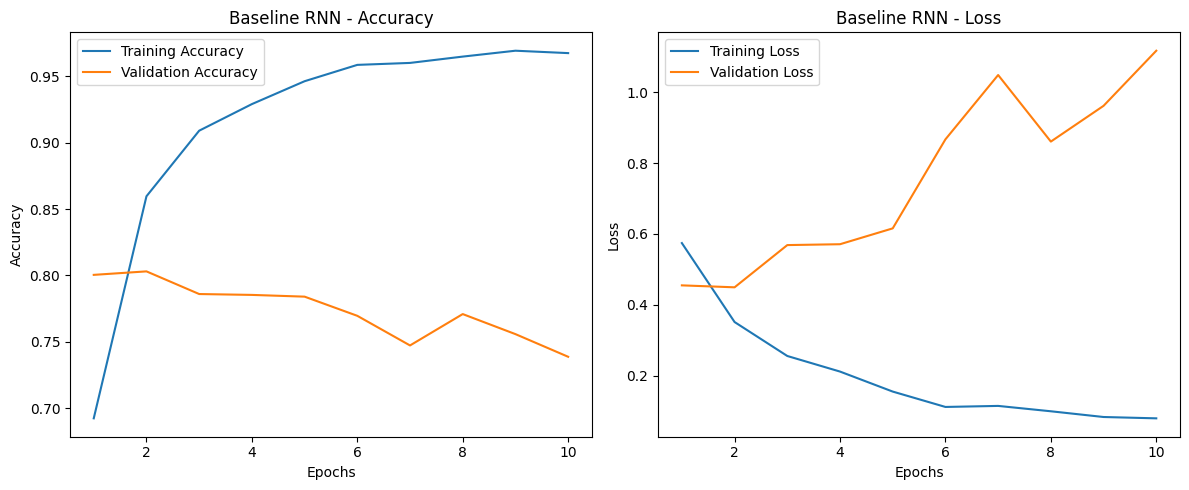

In [13]:
# Plot for all models
plot_training_history(history_baseline, "Baseline RNN")

The baseline RNN shows strong improvement in training accuracy, reaching over 95% by epoch 10. However, validation accuracy peaks early and then gradually declines, while validation loss continues to rise. This indicates that the model is overfitting, it performs well on the training data but struggles to generalize to unseen examples

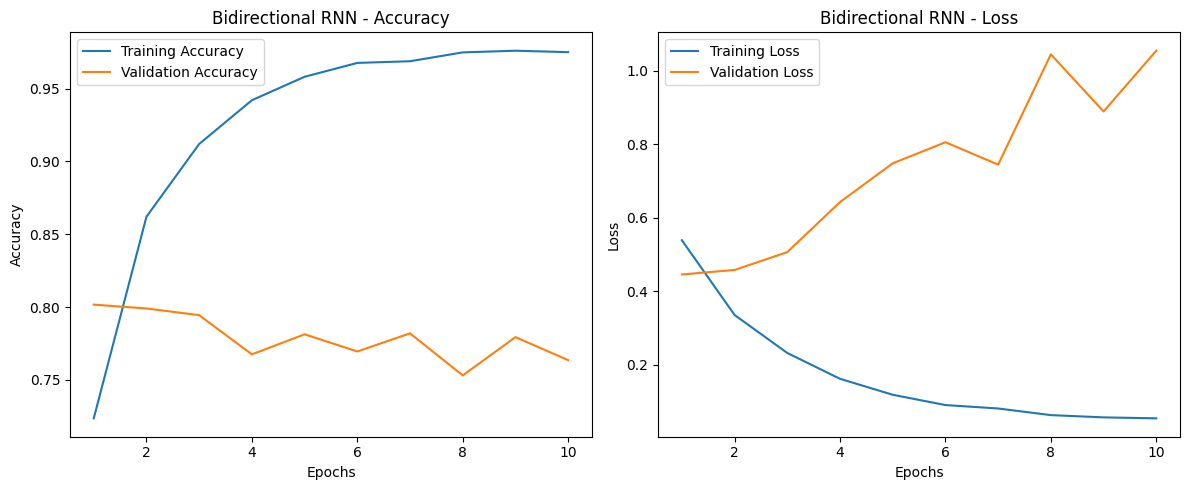

In [14]:
plot_training_history(history_bidirectional, "Bidirectional RNN")

The bidirectional RNN shows strong training accuracy, crossing 97% by epoch 10. However, validation accuracy begins to decline after the first few epochs, and validation loss steadily increases throughout training. This indicates overfitting, with the model learning the training data well but failing to generalize better than the baseline RNN in this run.

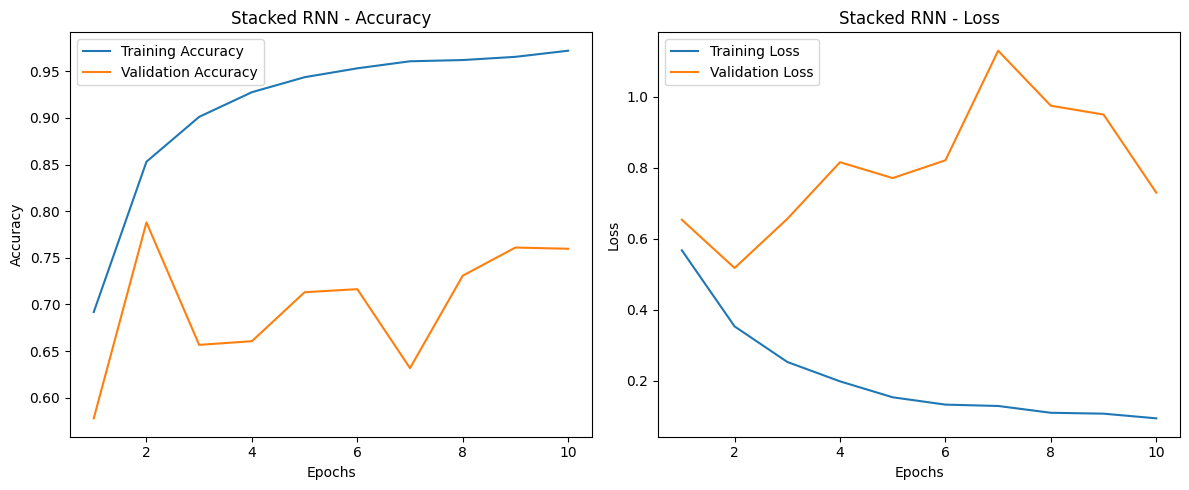

In [15]:
plot_training_history(history_stacked, "Stacked RNN")

The stacked RNN achieves high training accuracy, but validation accuracy fluctuates significantly throughout training and remains lower overall. The validation loss is unstable, with sharp rises and falls across epochs. This suggests the model may be overfitting and having difficulty generalizing, likely due to the increased depth being too complex for the dataset without further regularization or tuning.

In [16]:

# Build comparison table
baseline_val_acc = history_baseline.history['val_accuracy'][-1]
bidirectional_val_acc = history_bidirectional.history['val_accuracy'][-1]
stacked_val_acc = history_stacked.history['val_accuracy'][-1]

results_df = pd.DataFrame({
    'Model': ['Baseline RNN', 'Bidirectional RNN', 'Stacked RNN'],
    'Validation Accuracy': [baseline_val_acc, bidirectional_val_acc, stacked_val_acc]
})
results_df['Validation Accuracy'] = results_df['Validation Accuracy'].round(4)

# Display comparison table
print("Validation Accuracy Comparison:\n")
display(results_df)


Validation Accuracy Comparison:



,Model,Validation Accuracy
0,Baseline RNN,0.7387
1,Bidirectional RNN,0.7636
2,Stacked RNN,0.7597


### Predicting on Test Set and Preparing Kaggle Submission

Now that our models have been trained and evaluated, we use them to generate predictions on the unseen test set provided by Kaggle. This test set contains over 3,200 tweets without labels. We first clean and preprocess the tweet text using the same pipeline applied to the training data, including tokenization and padding. The processed text is then passed through each trained RNN model to obtain predictions. These predictions are thresholded at 0.5 to produce binary labels (0 for non-disaster, 1 for disaster). Finally, we format the predictions into a CSV file in the required Kaggle format and submit it to evaluate our model's performance on the public leaderboard.

Among the trained models, I used the predictions from the **bidirectional LSTM** for submission, as it achieved the highest validation accuracy in the final run.


In [11]:
# Function to generate submission file
def generate_submission(test_df, predictions, filename="submission.csv"):
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    
    submission_df = pd.DataFrame({
        'id': test_df['id'],
        'target': predicted_labels
    })
    
    submission_df.to_csv(filename, index=False)
    print(f"Submission file saved as: {filename}")

# generate submission files for all models
generate_submission(test_df, preds_baseline, "submission_baseline.csv")
generate_submission(test_df, preds_bidirectional, "submission_bidirectional.csv")
generate_submission(test_df, preds_stacked, "submission_stacked.csv")


Submission file saved as: submission_baseline.csv
Submission file saved as: submission_bidirectional.csv
Submission file saved as: submission_stacked.csv


### Analysis and Discussion

Among the three RNN models, the **bidirectional LSTM** achieved the highest validation accuracy in the final run, demonstrating that learning from both past and future word context improves classification performance on short tweets. The **stacked LSTM model** showed competitive performance but displayed fluctuating validation metrics, likely due to its increased complexity and sensitivity to hyperparameters. The **baseline RNN**, while simpler, still performed reasonably well and served as a solid foundation for comparison.

Adjusting the **dropout rate** (from 0.5 to 0.3) in the bidirectional model may have contributed to better generalization, while lowering the **learning rate** (to 0.0005) in the stacked model appeared to improve training stability without significantly boosting validation accuracy. Overall, the use of a **bidirectional LSTM layer** was the most impactful architectural decision in improving model performance under the current training setup.


## Conclusion (15 pts)

In this project, I used Recurrent Neural Networks (RNNs) to classify whether tweets are about real disasters or not. I started with a simple baseline model using a single LSTM layer, and then experimented with two additional architectures: one using a bidirectional LSTM and another using stacked LSTM layers with batch normalization.

Among the three models, the **bidirectional LSTM** performed best on the validation set. By processing the tweet text in both forward and backward directions, it was able to capture more contextual meaning — which is especially helpful for short and informal texts like tweets. The **stacked LSTM** model showed competitive performance but slightly underperformed, likely due to its increased complexity and limited training data. The **baseline model**, although simpler, still performed reasonably well and served as a strong starting point.

This project highlighted the importance of testing different model architectures and tuning hyperparameters to improve performance. Even modest changes, such as using a bidirectional layer or adjusting dropout, can lead to meaningful improvements in validation accuracy.
